In [1]:
import pandas as pd
import arviz as az
import numpy as np
from utils import *
import warnings
warnings.filterwarnings('ignore')
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

def prepare_test_data(mus, sigmas, n=100):

    # Set the random seed for reproducibility
    np.random.seed(123)

    # Generate random values for three clusters
    cluster1 = np.random.normal(loc=mus[0], scale=sigmas[0], size=n)
    cluster2 = np.random.normal(loc=mus[1], scale=sigmas[1], size=n)
    cluster3 = np.random.normal(loc=mus[2], scale=sigmas[2], size=n)

    # Combine the clusters into a single array
    data = np.concatenate([cluster1, cluster2, cluster3])

    # Create the DataFrame
    df = pd.DataFrame(data, columns=['Value'])
    return df

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = prepare_test_data(mus=[10, 20, 5], sigmas=[3, 3, 3])

In [20]:
df = get_data(
    'AAPL', 
    '2023-05-29', '2023-06-02')
df_og= df.copy()


[*********************100%***********************]  1 of 1 completed


In [22]:
df = get_returns(df)

In [24]:
df['moving_average'] = df['returns'].rolling(10, closed='left').mean()

# volatility std * root(T)
df['volatility'] = df['returns'].rolling(10, closed='left').std() * np.sqrt(10) * 1000

In [25]:
# drop na rows
df = df.dropna()

In [26]:
df = df[['returns', 'volatility']]

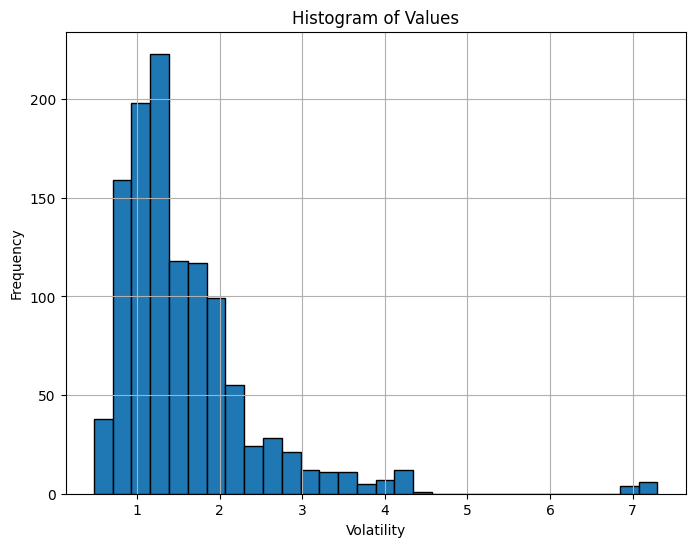

Only 2 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, sigmas, mus]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to exec

Sampling 4 chains for 10 tune and 2 draw iterations (40 + 8 draws total) took 50 seconds.


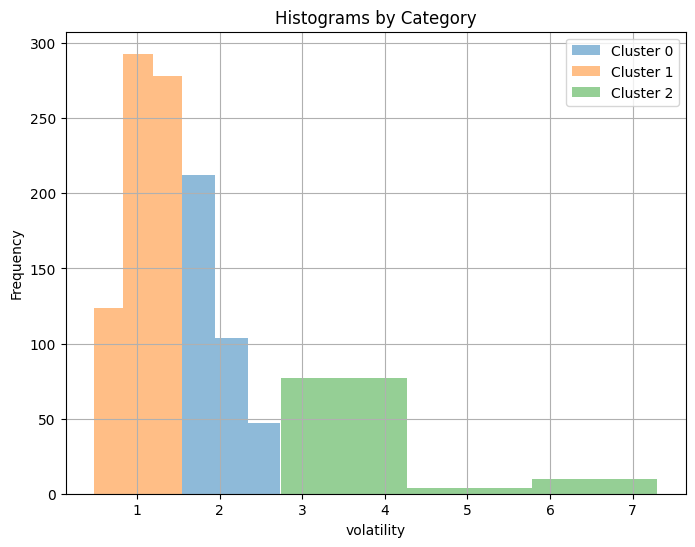

In [28]:
def assign_volatility_cluster(df, mus=[1,2,3], sigmas=[1,1,1]):
    """
    Assigns a volatility cluster to each value in the DataFrame.
    Give a df with a column named 'Value', this should be the volatility measure of a given window. 
    Let the index be the window or any arbitrary index.
    """
    # Plot the histogram of values
    plt.figure(figsize=(8, 6))
    plt.hist(df['volatility'], bins=30, edgecolor='black')
    plt.xlabel('Volatility')
    plt.ylabel('Frequency')
    plt.title('Histogram of Values')
    plt.grid(True)
    plt.show()
    # df drop rows with nan
    df.dropna(inplace=True)
    # Prepare the data
    
    values = df['volatility'].values

    with pm.Model() as model:
        # Specify the number of clusters
        k = 3
        # Priors for the cluster parameters
        mus = pm.Normal('mus', mu=mus, sd=1, shape=k)
        sigmas = pm.HalfNormal('sigmas', sd=1, shape=k)
        weights = pm.Dirichlet('weights', a=np.ones(k))

        # Likelihood
        likelihood = pm.NormalMixture('likelihood', w=weights, mu=mus, sd=sigmas, observed=values)

        # Sample from the posterior
        trace = pm.sample(2, tune=10)
        
    cluster_means = np.array(trace['mus'][-1])
    diff = cluster_means - df['volatility'].values[:, np.newaxis]
    cluster = np.argmin(np.abs(diff), axis=1)
    df['cluster'] = cluster


    # Separate values based on the category column
    category3_values = df[df['cluster'] == 0]['volatility']
    category1_values = df[df['cluster'] == 1]['volatility']
    category2_values = df[df['cluster'] == 2]['volatility']

    # Plot the histograms
    plt.figure(figsize=(8, 6))
    plt.hist(category3_values, bins=3, alpha=0.5, label='Cluster 0')
    plt.hist(category1_values, bins=3, alpha=0.5, label='Cluster 1')
    plt.hist(category2_values, bins=3, alpha=0.5, label='Cluster 2')
    # plt.xlim([0, 3])
    plt.xlabel('volatility')
    plt.ylabel('Frequency')
    plt.title('Histograms by Category')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df, trace

    # Extract the cluster assignments

df_clusters, trace = assign_volatility_cluster(df)

In [29]:
# df_clusters.value_counts('cluster')
df_clusters.value_counts('cluster') 

cluster
1    695
0    363
2     91
Name: count, dtype: int64

In [30]:
# join df_clusters and df_og
df_clusters = df_clusters.join(df_og, how='left')
df_clusters.reset_index(inplace=True)
df_clusters.head()

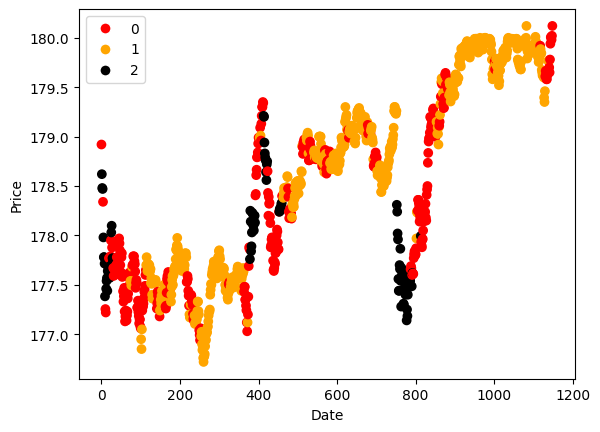

In [86]:
#import mcolors
from matplotlib import colors as mcolors

# Get unique categories and assign corresponding color map
unique_categories = sorted(df_clusters['cluster'].unique())  # Sort the unique categories
color_map = mcolors.ListedColormap(['red', 'orange', 'black'])  # Define specific colors for the categories

# Plot scatter points with color based on cluster
norm = mcolors.Normalize(vmin=0, vmax=len(unique_categories)-1)
plt.scatter(df_clusters.index, df_clusters['High'], c=df_clusters['cluster'].astype('category').cat.codes,
            cmap=color_map, norm=norm)

# Create a legend with matching colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(norm(i)), markersize=8)
                 for i, _ in enumerate(unique_categories)]
plt.legend(legend_labels, unique_categories)

# Set labels for x and y axes
plt.xlabel('Date')
plt.ylabel('Price')

# Display the plot
plt.show()


In [87]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder() 
df['cluster'] = label_encoder.fit_transform(df['cluster'])

In [88]:
train_cluster_names = df.cluster.unique()
train_cluster_idx = df.cluster.values

n_train_types = len(df.cluster.unique())

df[['cluster', 'volatility']].head()

,cluster,volatility
Datetime,,
2023-05-30 09:41:00-04:00,0,2.638388
2023-05-30 09:42:00-04:00,2,3.464053
2023-05-30 09:43:00-04:00,2,3.599182
2023-05-30 09:44:00-04:00,2,3.003752
2023-05-30 09:45:00-04:00,0,2.656763


Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano 

Sampling 4 chains for 100 tune and 20 draw iterations (400 + 80 draws total) took 480 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.05007168208080472, but should be close to 0.9. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10055179073506922, but should be close to 0.9. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.858479134609934e-15, but should be close to 0.9. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 6.648426094366503e-05, but should be close to 0.

array([[<Axes: title={'center': 'α_μ_tmp'}>,
        <Axes: title={'center': 'α_μ_tmp'}>],
       [<Axes: title={'center': 'β_μ'}>, <Axes: title={'center': 'β_μ'}>],
       [<Axes: title={'center': 'α_σ_tmp'}>,
        <Axes: title={'center': 'α_σ_tmp'}>],
       [<Axes: title={'center': 'β_σ'}>, <Axes: title={'center': 'β_σ'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

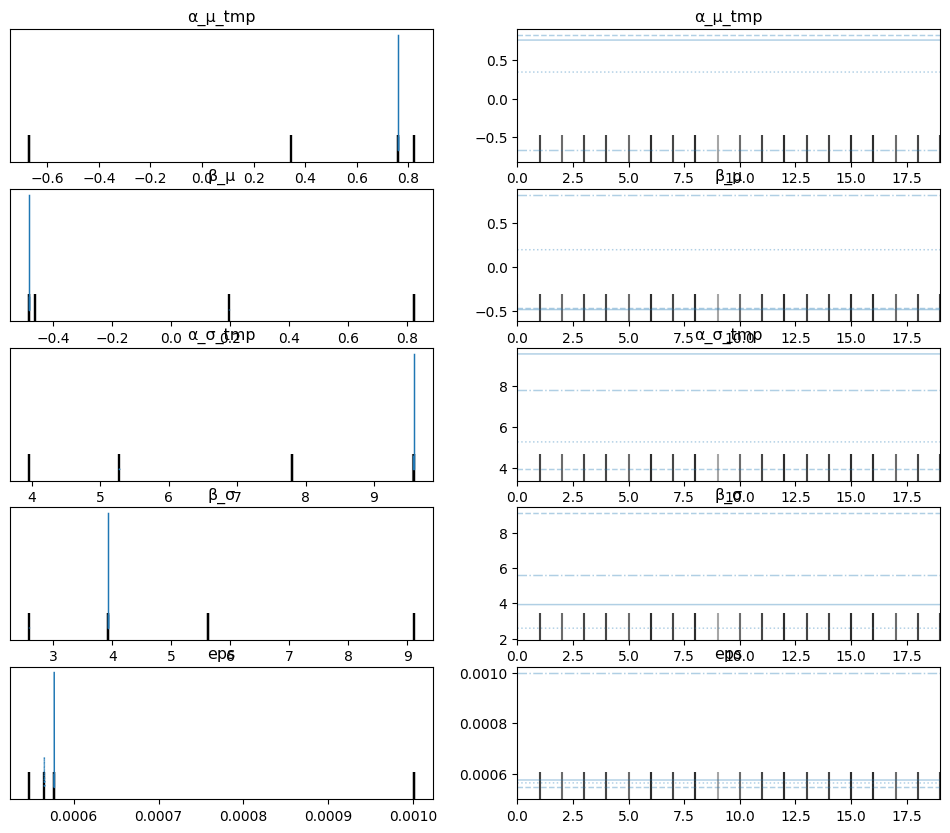

In [92]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    return_est = α_tmp[train_cluster_idx] + β[train_cluster_idx]*df.cluster.values

    # Data likelihood
    return_like = pm.Normal('return_like', mu=return_est, sd=eps, observed=df.returns)
    
with hierarchical_model:
    hierarchical_trace = pm.sample(20, tune=100, target_accept=.9)
    
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps'])


Got error No model on context stack. trying to find log_likelihood in translation.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

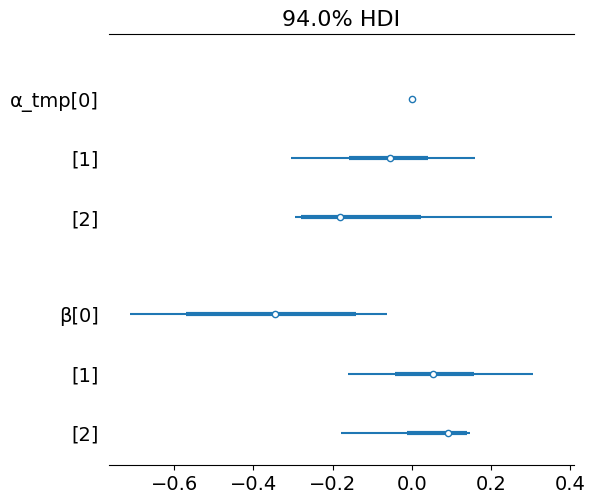

In [94]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True)

In [93]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(df.returns.values, ppc['return_like'])

r2        0.357163
r2_std    0.043637
dtype: float64